<a href="https://colab.research.google.com/github/datafilik/mobile-nextgen-wireless-comms-rsrch/blob/master/neuralMimoOfdmSystemV1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Created on Thu Oct 20 04:10:59 2022
@Title: Mutliuser MIMO OFDM sytem with neural receiver simualtions
@author: voche
"""
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to use
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)
        
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

############################################
## Channel configuration
carrier_frequency = 28e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
#speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 200 #30000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results

stream_manager = StreamManagement(np.array([[1]]),1) # Receiver-transmitter association matrix. One stream per transmitter

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)


class ResidualBlock(Layer):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.

    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer

    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):
    r"""
    Keras layer implementing a residual convolutional neural receiver.

    This neural receiver is fed with the post-DFT received samples, forming a resource grid of size num_of_symbols x fft_size, and computes LLRs on the transmitted coded bits.
    These LLRs can then be fed to an outer decoder to reconstruct the information bits.

    As the neural receiver is fed with the entire resource grid, including the guard bands and pilots, it also computes LLRs for these resource elements.
    They must be discarded to only keep the LLRs corresponding to the data-carrying resource elements.

    Input
    ------
    y : [batch size, num rx antenna, num ofdm symbols, num subcarriers], tf.complex
        Received post-DFT samples.

    no : [batch size], tf.float32
        Noise variance. At training, a different noise variance value is sampled for each batch example.

    Output
    -------
    : [batch size, num ofdm symbols, num subcarriers, num_bits_per_symbol]
        LLRs on the transmitted bits.
        LLRs computed for resource elements not carrying data (pilots, guard bands...) must be discarded.
    """

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z
    
class neuralEnabledMimoOfdmE2ESystem(Model):
    r"""
    Keras model that implements the end-to-end systems.

    As the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver) share most of
    the link components (transmitter, channel model, outer code...), they are implemented using the same Keras model.

    When instantiating the Keras model, the parameter ``system`` is used to specify the system to setup,
    and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated.
    The ``training`` parameter is only relevant when the neural

    At each call of this model:
    * A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
    * A batch of channel realizations is randomly sampled and applied to the channel inputs
    * The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
      Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends
      on the specified ``system`` parameter.
    * If not training, the outer decoder is applied to reconstruct the information bits
    * If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits

    Parameters
    -----------
    system : str
        Specify the receiver to use. Should be one of 'baseline-perfect-csi', 'baseline-ls-estimation' or 'neural-receiver'

    training : bool
        Set to `True` if the system is instantiated to be trained. Set to `False` otherwise. Defaults to `False`.
        If the system is instantiated to be trained, the outer encoder and decoder are not instantiated as they are not required for training.
        This significantly reduces the computational complexity of training.
        If training, the bit-metric decoding (BMD) rate is computed from the transmitted bits and the LLRs. The BMD rate is known to be
        an achievable information rate for BICM systems, and therefore training of the neural receiver aims at maximizing this rate.

    Input
    ------
    batch_size : int
        Batch size

    no : scalar or [batch_size], tf.float
        Noise variance.
        At training, a different noise variance should be sampled for each batch example.

    Output
    -------
    If ``training`` is set to `True`, then the output is a single scalar, which is an estimation of the BMD rate computed over the batch. It
    should be used as objective for training.
    If ``training`` is set to `False`, the transmitted information bits and their reconstruction on the receiver side are returned to
    compute the block/bit error rate.
    """

    def __init__(self, system, speed, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of `system`
        if "baseline" in system:
            if system == 'baseline-perfect-csi': # Perfect CSI
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation': # LS estimation
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            # Components required by both baselines
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y,h = self._channel([x_rg, no_])

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of ``system``
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h) # Extract non-null subcarriers
                err_var = 0.0 # No channel estimation error when perfect CSI knowledge is assumed
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no]) # LS channel estimation with nearest-neighbor
            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
            no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_]) # Demapping
        elif self._system == "neural-receiver":
            # The neural receover computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected

        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation
        
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

Number of GPUs available : 0


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5127e-01 | 1.0000e+00 |       44770 |      178176 |          128 |         128 |         8.4 |reached target block errors
     -4.5 | 2.3663e-01 | 1.0000e+00 |       42162 |      178176 |          128 |         128 |         0.9 |reached target block errors
     -4.0 | 2.1576e-01 | 1.0000e+00 |       38443 |      178176 |          128 |         128 |         0.9 |reached target block errors
     -3.5 | 1.9572e-01 | 1.0000e+00 |       34872 |      178176 |          128 |         128 |         0.9 |reached target block errors
     -3.0 | 1.6484e-01 | 1.0000e+00 |       29370 |      178176 |          128 |         128 |         0.9 |reached target block errors
     -2.5 | 1.0694e-01 | 1.0000e+00 |       19055 |      178176 |

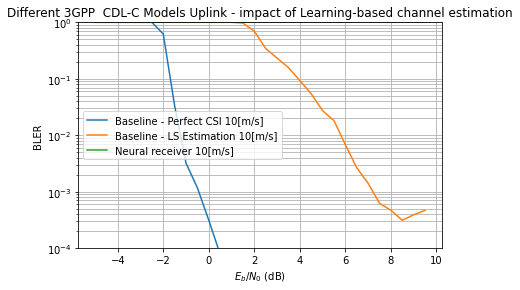

In [3]:
# STUDIES    
# mobility studies
# Dictionnary storing the evaluation results
#BLER = {}

BLER = {
    "baseline-perfect-csi": [],
    "baseline-ls-estimation": [],
    "neural-receiver": []        
}


MOBILITY_SIMS = {
    "speed" : [10] #[0.0, 20.0, 30.0]
}

for speed in MOBILITY_SIMS["speed"]:

    # Train neural receiver
    model = neuralEnabledMimoOfdmE2ESystem('neural-receiver', speed=speed, training=True)
    
    optimizer = tf.keras.optimizers.Adam()
    
    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            # Tensorflow optimizers only know how to minimize loss function.
            # Therefore, a loss function is defined as the additive inverse of the BMD rate
            loss = -rate
        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        # Periodically printing the progress
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')
    
    # Save the weights in a file
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)
        
    
    
    model = neuralEnabledMimoOfdmE2ESystem('baseline-perfect-csi', speed=speed)
    _,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
    BLER['baseline-perfect-csi'].append(list(bler.numpy()))
    
    model = neuralEnabledMimoOfdmE2ESystem('baseline-ls-estimation', speed=speed)
    _,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
    BLER['baseline-ls-estimation'].append(list(bler.numpy()))
    
    model = neuralEnabledMimoOfdmE2ESystem('neural-receiver', speed=speed)
    
    # Run one inference to build the layers and loading the weights
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    
    # Evaluations
    _,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
    BLER['neural-receiver'].append(list(bler.numpy()))


plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")

i=0
legend = []
for speed in MOBILITY_SIMS["speed"]:
    # Baseline - Perfect CSI
    plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi'][i], label="Baseline - Perfect CSI {}[m/s]".format(speed))
    # Baseline - LS Estimation
    plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation'][i], label="Baseline - LS Estimation {}[m/s]".format(speed))
    # Neural receiver
    plt.semilogy(ebno_dbs, BLER['neural-receiver'][i], label="Neural receiver {}[m/s]".format(speed))
    
    i+= 1
    
plt.legend()
plt.ylim((1e-4, 1.0))
plt.tight_layout()
#plt.title("Different 3GPP  CDL-{} Models Uplink - impact of UT mobility".format(cdl_model));
plt.title("Different 3GPP  CDL-{} Models Uplink - impact of Learning-based channel estimation".format(cdl_model));